# Day of the Month Seasonality

Simple investigation whether going long on several days of the month are better than others.

Key Code Assumptions:
- Data contains all working days, such that the number of the business day can be inferred purely based on the 'Date' column
- Metrics are computed on the price at the close
- The return on the data is the total return, and does not include other aspects such as dividends or coupons

### Imports and Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### PARAMETERS ###
PERIOD_AHEAD = 250

### CONSTANTS ###
SORTED_DAYNAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

In [3]:
DATA = (
    pd.read_csv('../data/ISHARES_MSCI_USA_MOMENTUM_FACTOR.csv')
    .loc[:,['Date', 'Close']]
)

DATA['Date'] = (
    pd.to_datetime(DATA['Date'], format='%d-%m-%Y')
)

display(DATA)

,Date,Close
0,2013-04-18,44.107418
1,2013-04-19,44.107418
2,2013-04-22,44.107418
3,2013-04-23,45.233490
4,2013-04-24,44.661800
...,...,...
2940,2024-12-20,209.110001
2941,2024-12-23,209.929993
2942,2024-12-24,212.630005
2943,2024-12-26,212.929993


### Working Day Number

For clarity: the working day number represents how many working days there were before the current working day, counting from the start of the month. Indexing starts at zero.

In [4]:
series_working_dates = DATA.copy()

series_working_dates['Year_Month'] =(
    series_working_dates['Date'].dt.to_period('M')
)

series_working_dates = (
    series_working_dates
    .groupby(['Year_Month'])
    .cumcount()
    # .groupby(0)
    # .count()
)

display(series_working_dates)

0        0
1        1
2        2
3        3
4        4
        ..
2940    14
2941    15
2942    16
2943    17
2944    18
Length: 2945, dtype: int64

### Add Day Indices

Current indices are:
- Num_Workday: the working day number
- Day_Name: the 'dd' number of the date from a yyyy-mm-dd date
- Day_Name: the name of the day, i.e. Monday, Tuesday, ...

In [5]:
data_working_day = (
    DATA
    .copy()
)

data_working_day['Num_Workday'] = series_working_dates

data_working_day['Day_Name'] = data_working_day['Date'].dt.day_name()

data_working_day['Day_Number'] = data_working_day['Date'].dt.day

display(data_working_day)

,Date,Close,Num_Workday,Day_Name,Day_Number
0,2013-04-18,44.107418,0,Thursday,18
1,2013-04-19,44.107418,1,Friday,19
2,2013-04-22,44.107418,2,Monday,22
3,2013-04-23,45.233490,3,Tuesday,23
4,2013-04-24,44.661800,4,Wednesday,24
...,...,...,...,...,...
2940,2024-12-20,209.110001,14,Friday,20
2941,2024-12-23,209.929993,15,Monday,23
2942,2024-12-24,212.630005,16,Tuesday,24
2943,2024-12-26,212.929993,17,Thursday,26


### Compute Returns

Columns produced:
- Single_Period_Ahead_Return: return over one row ahead
- Test_Period_Ahead_Return: total return over the test period
- Test_Period_Ahead_Avg: average daily return over the test period

In [6]:
data_returns = (
    data_working_day.copy()
)

data_returns['Test_Period_Ahead_Return'] = (
    data_returns['Close'].shift(-PERIOD_AHEAD)
)

data_returns['Single_Period_Ahead_Return'] = (
    data_returns['Close'].shift(-1)
)


data_returns['Test_Period_Ahead_Return'] = (
    100 * (data_returns['Test_Period_Ahead_Return'] - data_returns['Close']) / np.abs(data_returns['Close'])
)

data_returns['Single_Period_Ahead_Return'] = (
    100 * (data_returns['Single_Period_Ahead_Return'] - data_returns['Close']) / np.abs(data_returns['Close'])
)

data_returns['Test_Period_Ahead_Avg'] = (
    data_returns['Single_Period_Ahead_Return']
    .shift(-PERIOD_AHEAD)
    .rolling(window=PERIOD_AHEAD)
    .apply(np.mean)
)

data_returns = (
    data_returns
    .dropna()
)

display(data_returns)

,Date,Close,Num_Workday,Day_Name,Day_Number,Test_Period_Ahead_Return,Single_Period_Ahead_Return,Test_Period_Ahead_Avg
249,2014-04-14,50.868721,9,Monday,14,23.491597,0.896848,0.083760
250,2014-04-15,51.324936,10,Tuesday,15,22.255444,1.418831,0.079387
251,2014-04-16,52.053150,11,Wednesday,16,20.937558,0.404509,0.077994
252,2014-04-17,52.263710,12,Thursday,17,20.518257,0.721843,0.070257
253,2014-04-21,52.640972,13,Monday,21,18.203596,0.816674,0.071329
...,...,...,...,...,...,...,...,...
2689,2023-12-21,155.056351,14,Thursday,21,32.332537,0.089620,0.126461
2690,2023-12-22,155.195312,15,Friday,22,34.739895,0.556383,0.125804
2691,2023-12-26,156.058792,16,Tuesday,26,34.519811,0.248028,0.129956
2692,2023-12-27,156.445862,17,Wednesday,27,35.912834,-0.057106,0.130749


### Compute Volatility

Columns Produced:
- Test_Period_Ahead_Std: standard deviation computed by numpy.var, over the observations of single-period returns over the test period

In [7]:
data_volatility = (
    data_returns.copy()
)

data_volatility['Test_Period_Ahead_Std'] = (
    data_volatility['Single_Period_Ahead_Return']
    .shift(-PERIOD_AHEAD)
    .rolling(window=PERIOD_AHEAD)
    .apply(np.var)
)

data_volatility['Test_Period_Ahead_Std'] = (
    np.sqrt(data_volatility['Test_Period_Ahead_Std'])
)

data_volatility = (
    data_volatility
    .dropna()
)

# data_volatility.to_csv('../data/processed.csv', index=False)

display(data_volatility)


,Date,Close,Num_Workday,Day_Name,Day_Number,Test_Period_Ahead_Return,Single_Period_Ahead_Return,Test_Period_Ahead_Avg,Test_Period_Ahead_Std
498,2015-04-10,63.147213,6,Friday,10,3.753580,-0.520398,0.022115,1.089126
499,2015-04-13,62.818596,7,Monday,13,4.124811,-0.113132,0.020096,1.089842
500,2015-04-14,62.747528,8,Tuesday,14,3.598711,0.325560,0.021115,1.090246
501,2015-04-15,62.951809,9,Wednesday,15,3.861678,0.056398,0.023142,1.090780
502,2015-04-16,62.987312,10,Thursday,16,4.387628,-1.212609,0.027610,1.087993
...,...,...,...,...,...,...,...,...,...
2439,2022-12-22,141.803848,15,Thursday,22,9.345658,1.089306,0.035432,0.855979
2440,2022-12-23,143.348526,16,Friday,23,8.264324,0.177306,0.036948,0.856564
2441,2022-12-27,143.602692,17,Tuesday,27,8.674002,-1.177742,0.042651,0.853198
2442,2022-12-28,141.911423,18,Wednesday,28,10.241909,0.544219,0.040246,0.852628


### Compute Sharpe

Columns Produced:
- Test_Period_Ahead_Sharpe: sharpe ratio over the test period

In [8]:
data_sharpe = (
    data_volatility.copy()
)

data_sharpe['Test_Period_Ahead_Sharpe'] = (
    data_sharpe['Test_Period_Ahead_Avg'] / data_sharpe['Test_Period_Ahead_Std']
)

display(data_sharpe)

,Date,Close,Num_Workday,Day_Name,Day_Number,Test_Period_Ahead_Return,Single_Period_Ahead_Return,Test_Period_Ahead_Avg,Test_Period_Ahead_Std,Test_Period_Ahead_Sharpe
498,2015-04-10,63.147213,6,Friday,10,3.753580,-0.520398,0.022115,1.089126,0.020305
499,2015-04-13,62.818596,7,Monday,13,4.124811,-0.113132,0.020096,1.089842,0.018440
500,2015-04-14,62.747528,8,Tuesday,14,3.598711,0.325560,0.021115,1.090246,0.019367
501,2015-04-15,62.951809,9,Wednesday,15,3.861678,0.056398,0.023142,1.090780,0.021216
502,2015-04-16,62.987312,10,Thursday,16,4.387628,-1.212609,0.027610,1.087993,0.025377
...,...,...,...,...,...,...,...,...,...,...
2439,2022-12-22,141.803848,15,Thursday,22,9.345658,1.089306,0.035432,0.855979,0.041393
2440,2022-12-23,143.348526,16,Friday,23,8.264324,0.177306,0.036948,0.856564,0.043135
2441,2022-12-27,143.602692,17,Tuesday,27,8.674002,-1.177742,0.042651,0.853198,0.049990
2442,2022-12-28,141.911423,18,Wednesday,28,10.241909,0.544219,0.040246,0.852628,0.047202


### Results

Contains computed metrics, averaged over:
1. The 'dd' date of 'dd-mm-yyyy' date
2. The workday number of the month
3. The day name

In [9]:
def aggregate_per_index(data_sharpe, name_col_index):
    data_per_workday = (
        data_sharpe
        .loc[:, [name_col_index, 'Test_Period_Ahead_Sharpe', 'Test_Period_Ahead_Return']]
        .groupby(name_col_index)
        .agg(
            Test_Period_Ahead_Sharpe_Mean=('Test_Period_Ahead_Sharpe', 'mean'),
            Test_Period_Ahead_Sharpe_Count=('Test_Period_Ahead_Sharpe', 'count'),
            Test_Period_Ahead_Return_Mean=('Test_Period_Ahead_Return', 'mean'),
            Test_Period_Ahead_Return_Count=('Test_Period_Ahead_Return', 'count')
        )
        .sort_values(by='Test_Period_Ahead_Sharpe_Mean', ascending=False)
    )

    data_per_workday['Test_Period_Ahead_Sharpe_Mean'].sort_index().plot()
    plt.show()
    data_per_workday['Test_Period_Ahead_Return_Mean'].sort_index().plot()
    plt.show()

    display(data_per_workday)


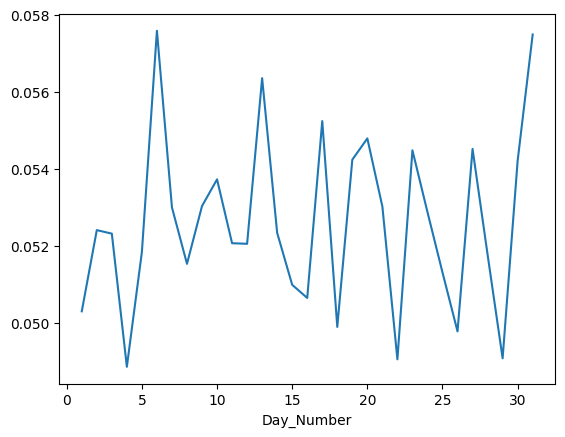

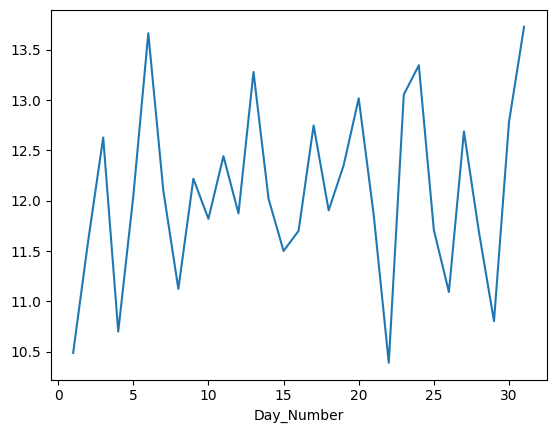

,Test_Period_Ahead_Sharpe_Mean,Test_Period_Ahead_Sharpe_Count,Test_Period_Ahead_Return_Mean,Test_Period_Ahead_Return_Count
Day_Number,,,,
6,0.057587,64,13.663728,64
31,0.057490,37,13.727179,37
13,0.056356,66,13.277868,66
17,0.055239,63,12.747274,63
20,0.054790,63,13.016687,63
27,0.054517,65,12.686570,65
23,0.054481,65,13.053806,65
19,0.054236,63,12.352593,63
30,0.054210,57,12.783284,57


In [10]:
aggregate_per_index(data_sharpe, 'Day_Number')

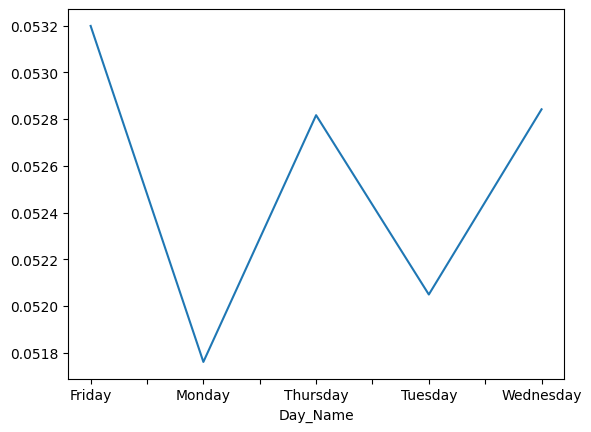

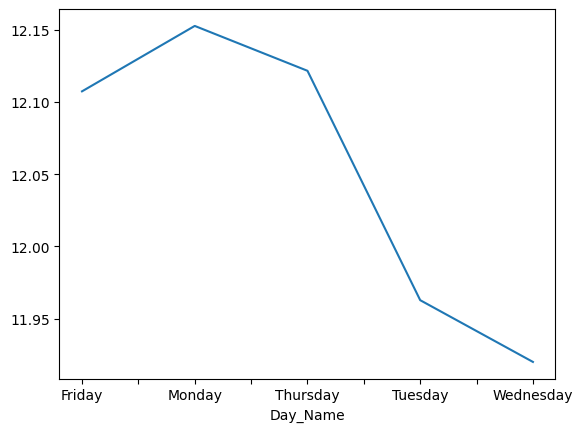

,Test_Period_Ahead_Sharpe_Mean,Test_Period_Ahead_Sharpe_Count,Test_Period_Ahead_Return_Mean,Test_Period_Ahead_Return_Count
Day_Name,,,,
Friday,0.053199,389,12.107313,389
Wednesday,0.052842,399,11.920071,399
Thursday,0.052817,394,12.121534,394
Tuesday,0.052049,400,11.962798,400
Monday,0.051760,364,12.152587,364


In [11]:
aggregate_per_index(data_sharpe, 'Day_Name')

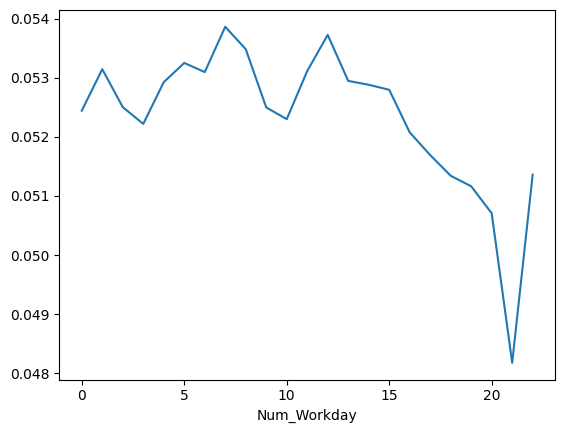

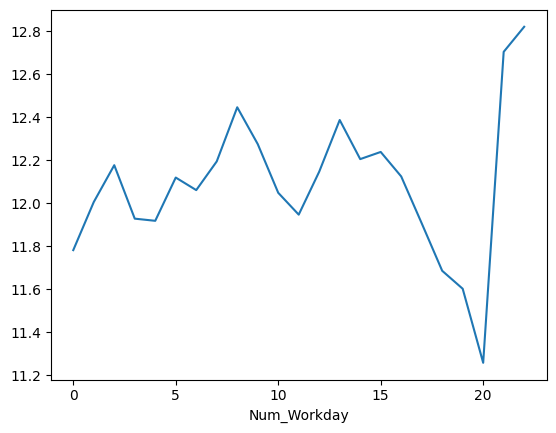

,Test_Period_Ahead_Sharpe_Mean,Test_Period_Ahead_Sharpe_Count,Test_Period_Ahead_Return_Mean,Test_Period_Ahead_Return_Count
Num_Workday,,,,
7,0.053865,93,12.195253,93
12,0.053728,93,12.147607,93
8,0.053486,93,12.447259,93
5,0.053253,92,12.120157,92
1,0.053147,92,12.006243,92
11,0.053115,93,11.947539,93
6,0.053098,93,12.061732,93
13,0.052948,93,12.388028,93
4,0.052927,92,11.918838,92


In [12]:
aggregate_per_index(data_sharpe, 'Num_Workday')

Results of S&P 500 Total Return Index:

Looking at returns by day number and day name do not seem to be helpful, as the former seems to jump around (in the charts), while the latter looks very similar for each day

From the Num_Workday results:
- Look at rows where average sharpe ratio over the test period is close to 0.6
- Observe we have the best results at around the end of the first week / beginning of the second week (Num_Workday in {3, 4, 5, 6}), and around the third week (Num_Workday in {12, 13, 14, 15, 16})
- Possible explanation: at the start of the month, returns are still affected by month-end flows, which would 'calm down' after the first few business days. 

